## PROJECT 5.  
Gorlova Kristina

## ЦЕЛЬ:
Исследовать поведение пользователей сервиса по доставке продуктов на дом и эффективности каналов их привлечения.

## Гипотезы:
1) Так как регистрация является обязательным условием для совершения покупки, она является этапом воронки продаж, на котором мы теряем больше всего потенциальных покупателей.
2) Существует канал привлечения пользователей, наиболее эффективный по привлечению новых пользователей и конверсии в первую покупку, дополнительные вложения в который могут стимулировать дополнительный рост охвата и прибыли компании.

## ЗАДАЧИ:
1) Оценить динамику поведения пользователей в день установки приложения и в остальные дни.
2) Определить на каком этапе воронки продаж отваливается больше всего зарегистрированных и незарегистрированных пользователей.
3) Проанализировать с какого канала привлечения клиентов приходит больше всего пользователей, с какого канала выше конверсия в покупку, выручка и медианный чек.
4) Оценить эффективность затрат на каналы привлечения (ROMI).
5) Определить самую большую и активную когорту по первому посещению.
6) Определить наиболее большую и активную когорту по первой покупке, проанализировать динамику активности этих когорт, соотнести эти данные с каналами привлечения пользователей.

## Оценим эффективность каналов привлечения и воронку продаж

In [1]:
# импорт библиотек анализа и визуализации данных
import pandas as pd
import matplotlib.pyplot as plt
import cufflinks as cf 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
init_notebook_mode(connected=True)
cf.go_offline()
# получение и проверка корректности отображения данных
user_behavior = pd.read_csv('SF_case_data.csv')
user_behavior.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads


In [2]:
# получение сведений о таблице
user_behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747968 entries, 0 to 2747967
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   date          object 
 1   event         object 
 2   purchase_sum  float64
 3   os_name       object 
 4   device_id     int64  
 5   gender        object 
 6   city          object 
 7   utm_source    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 167.7+ MB


In [3]:
# приведение столбца с датами к типу datetime(64)
user_behavior.date = pd.to_datetime(user_behavior.date)

In [4]:
# построение графика с динамикой совершения действий пользователей по времени
user_behavior.groupby('date')['event'].count().iplot(
    kind='line',
    title='Ежедневная динамика событий',
    xTitle= 'Дата',
    yTitle= 'Количество событий',
    color = 'blue',
    showgrid=False
)

По пикам на графике можно определить, что наибольшее количество действий было совершено 10 января, 6 марта, 14 февраля, 14 января и 21 февраля 2020 года. Возможно эти даты совпадают с началом каких-то рекламных акций или распродаж. Минимальное количество действий пользователями совершено 01, 04, 06 января, что может быть связано с новогодними праздниками и 31 марта.

In [5]:
# далее для анализа данных нам потребуются даты первых совершенных пользователями событий, поэтому создаем сводную таблицу по первым событиям
user_behavior_pivot = user_behavior.pivot_table(values = 'date',
                                              index = 'device_id',
                                              columns = 'event',
                                              aggfunc = 'min').reset_index()
# переименуем столбцы для удобства добавления в таблицу с действиями пользователей
user_behavior_pivot.columns = ['device_id', 'app_install','first_app_start','first_choose_item','first_purchase','register','first_search','first_tap_basket']

In [6]:
# добавляем дату установки приложения к таблице с действиями пользователей по device_id
user_behavior = user_behavior.merge(user_behavior_pivot[['device_id', 'app_install']],
                                    on = 'device_id',
                                    how = 'left')

In [7]:
# добавляем столбец-определитель, указывающий, что данное действие совершено пользователем в день установки приложения и смотрим размеры этих групп по открытию приложений
user_behavior['install_group'] = user_behavior.apply(lambda x: 'Установили в этот же день' if x['app_install'] == x['date'] else 'Остальные', axis = 1)
user_behavior[user_behavior['event'] == 'app_start']['install_group'].value_counts()

install_group
Остальные                    594108
Установили в этот же день    154597
Name: count, dtype: int64

In [8]:
# создаем таблицу, отображающую количество пользователей, которые открывают приложения каждой группы по дням
user_behavior_app_start_group = user_behavior[user_behavior['event'] == 'app_start'].groupby(['date','install_group']).size().reset_index(name = 'users')
# поучаем сводную, столбцами которой являются дата и группы пользователей
user_behavior_app_start_group_piv = user_behavior_app_start_group.pivot(index='date', columns='install_group', values='users').reset_index()
# строим график
fig = user_behavior_app_start_group_piv.iplot(
    kind='line',
    x='date', 
    y=['Остальные', 'Установили в этот же день'],
    title='Ежедневная динамика открытия приложений по группам',
    xTitle= 'Дата',
    yTitle= 'Количество открытий',
    colors = ['blue', 'green'],
    showgrid=False,
    asFigure=True)
fig.show()

Количество открытий приложений пользователями из группы "Установили в тот же день" превышает количество открытий приложений пользователями из группы "Остальные" только дважды: 01 января и 10 января. Доля действий новых пользователей в данные дни является максимальной. 

In [9]:
# смотрим долю трафика с инсталлов
user_behavior_app_start_group_piv['proportion'] = user_behavior_app_start_group_piv['Установили в этот же день'] / ( user_behavior_app_start_group_piv['Установили в этот же день']
                                                                                                        + user_behavior_app_start_group_piv['Остальные'])
# строим график, отображающий долю трафика с инсталлов по дням
user_behavior_app_start_group_piv[['date','proportion']].iplot(
    kind='line',
    x='date', 
    y='proportion',
    title='Доля трафика с инсталлов, %',
    xTitle= 'Дата',
    yTitle= 'Доля трафика, %',
    color = 'blue',
    showgrid=False
)

Максимальная доля трафика с инсталлов наблюдается 01 января, 10 января, 14 января, 06 марта и 14 февраля. Возможно в эти дни была запущена какая-то рекламная кампания, направленная на привлечение новых пользователей.

In [10]:
# смотрим количество установок приложения по каналам привлечения
mask = (user_behavior['event'] == 'app_install')
user_behavior[mask]['utm_source'].value_counts()

utm_source
-                32460
yandex-direct    29368
google_ads       26286
vk_ads           23189
instagram_ads    20096
facebook_ads     13916
referal           9282
Name: count, dtype: int64

In [11]:
# Строим сводную таблицу, отображающую количество установок приложения по каналам привлечения
app_instapp_utm_source = user_behavior[mask].pivot_table(values = 'device_id', 
                                                         index = 'date',
                                                         columns = 'utm_source',
                                                         aggfunc = 'count').reset_index()
# Строим график
fig = app_instapp_utm_source.iplot(
    kind='line',
    x='date', 
    y=['-','facebook_ads','google_ads','instagram_ads','referal','vk_ads','yandex-direct'],
    title='Ежедневная динамика установки приложения по каналам привлечения',
    xTitle= 'Дата',
    yTitle= 'Количество установок',
    showgrid=False,
    asFigure=True)
fig.show()

По графику видно примерно сохраняющуюся пропорцию, и то, что больше всего установок приносят такие каналы как Яндекс, Гугл и ВК.

In [12]:
# добавляем в таблицу пользователей дату первого открытия приложения
user_behavior = user_behavior.merge(user_behavior_pivot[['device_id', 'first_app_start']],
                                    on = 'device_id',
                                    how = 'left')

In [13]:
# Строим сводную таблицу, отображающую количество первых открытий приложения по каналам привлечения
mask2 = (user_behavior['event'] == 'app_start')
app_start_utm_source = user_behavior[mask2].sort_values('date').drop_duplicates('device_id').pivot_table(values = 'device_id', 
                                                                                                         index = 'date',
                                                                                                         columns = 'utm_source',
                                                                                                         aggfunc = 'count').reset_index()
# Строим график
fig = app_start_utm_source.iplot(
    kind='line',
    x='date', 
    y=['-','facebook_ads','google_ads','instagram_ads','referal','vk_ads','yandex-direct'],
    title='Ежедневная динамика первых открытий приложения по каналам привлечения',
    xTitle= 'Дата',
    yTitle= 'Количество открытий',
    showgrid=False,
    asFigure=True)
fig.show()


Заметно, что данный график пиками повторяет график, соответствующий динамике установки приложения по каналам привлечения.

In [14]:
# строим таблицу с количеством пользователей, пришедшим по каналам привлечения
range_of_source = user_behavior[mask2].sort_values('date').drop_duplicates('device_id').pivot_table(values = 'device_id', 
                                                                                                    index = 'utm_source',
                                                                                                    aggfunc = 'count').reset_index()
range_of_source.columns = ['utm_source','app_start']
range_of_source

,utm_source,app_start
0,-,41456
1,facebook_ads,18844
2,google_ads,31437
3,instagram_ads,24818
4,referal,11983
5,vk_ads,27905
6,yandex-direct,34441


In [15]:
# строим круговую диаграмму рапределения пользователей по каналам привлечения
trace = go.Pie(labels=range_of_source['utm_source'], values=range_of_source['app_start'])
data = [trace]
# Определение макета графика
layout = go.Layout(title='Распределение пользователей по каналам привлечения', height = 400, width = 600)
# Построение графика iplot pie
fig = go.Figure(data=data, layout=layout)
iplot(fig)


Из данной диаграммы видно, что наибольшее количество новых пользователей пришло с Яндекс.Директ (18%), Гугл (16,5%) и ВК (14,5%). Меньше всего пользователей пришло с реферальной программы, Фейсбук и Инстаграм.

Далее рассмотрим воронку продаж по зарегистрированным и незарегистрированным пользователям.

In [16]:
# предварительно обработаем данные для оценки воронки продаж
user_behavior_copy= user_behavior.copy()
# создаем таблицу, в которую добавляем данные из таблицы с поведением пользователей, где типом события является регистрация, сортируем по дате и оставляем только первую дату для пользователя и 
# добавляется столбец-определитель, содержащий значение 1 для каждой строки
first_registration = user_behavior_copy[user_behavior_copy['event'] == 'register'].sort_values('date').drop_duplicates('device_id')
first_registration['finally_registered'] = 1
# добавляем в исходную таблицу столбец first_registration, который содержит дату первой регистрации для каждого уникального device_id, значение в этом столбце 
# берется из столбца date таблицы first_registration, где индексом является столбец device_id.
user_behavior_copy['first_registration'] = user_behavior_copy['device_id'].map(first_registration.set_index('device_id')['date'])
# добавляем в исходную таблицу столбец finally_registered, который содержит значение 1 для каждой строки, где регистрация была первым событием для данного device_id, значение 
# в этом столбце берется из столбца finally_registered таблицы first_registration, где индексом является столбец device_id
user_behavior_copy['finally_registered'] = user_behavior_copy['device_id'].map(first_registration.set_index('device_id')['finally_registered'])
# создаем новую таблицу already_reg, которая содержит только те строки из исходной таблицы, где значение столбца first_registration меньше значения столбца date
already_reg = user_behavior_copy[user_behavior_copy['first_registration'] < user_behavior_copy['date']]
# добавляем столбец-определитель, содержащий значение 1 для каждой строки
already_reg['registered'] = 1
# создаем таблицу, которая содержит только те строки из исходной таблицы, где значение первой регистрации равно 0
requires_reg1 = user_behavior_copy[(user_behavior_copy['first_registration'].isna() == True)]
# добавляем столбец-определитель, содержащий значение 0 для каждой строки
requires_reg1['registered'] = 0
# создаем таблицу, которая содержит только те строки из исходной таблицы, где дата первой регистрации больше или равна значению столбца date, то есть событие произошло ранее или в день регистрации
requires_reg2 =  user_behavior_copy[user_behavior_copy['first_registration'] >= user_behavior_copy['date']]
# добавляем столбец-определитель, содержащий значение 0 для каждой строки
requires_reg2['registered'] = 0
# объединяем созданные таблицы
user_behavior_copy = pd.concat([already_reg,requires_reg1,requires_reg2])
# группируем таблицу по столбцу registered и подсчитывается количество строк в каждой группе, предварительно отфильтровав данные по значению события tap_basket
user_behavior_copy[user_behavior_copy['event'] == 'tap_basket'].groupby('registered').count()


,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,app_install,install_group,first_app_start,first_registration,finally_registered
registered,,,,,,,,,,,,,
0,160409,160409,0,160409,160409,160409,160409,160409,130022,160409,160409,105031,105031
1,217256,217256,0,217256,217256,217256,217256,217256,177108,217256,217256,217256,217256


In [17]:
# создаем таблицу с действиями пользователей, которые были зарегистрированы
reg = user_behavior_copy[user_behavior_copy['registered'] == 1]

funnel_reg = pd.crosstab(reg.utm_source, reg.event, values=reg.device_id, aggfunc=pd.Series.nunique)
# добавляем столбцы, отображающие процент пользователей, перешедших от одного этапа к следующему
funnel_reg['1 step'] = funnel_reg['search']*100/funnel_reg['app_start']
funnel_reg['2 step'] = funnel_reg['choose_item']*100/funnel_reg['search']
funnel_reg['3 step'] = funnel_reg['tap_basket']*100/funnel_reg['choose_item']
funnel_reg['5 step'] = funnel_reg['purchase']*100/funnel_reg['tap_basket']
funnel_reg

event,app_start,choose_item,purchase,search,tap_basket,1 step,2 step,3 step,5 step
utm_source,,,,,,,,,
-,9482,8728,5492,9355,7850,98.660620,93.297702,89.940422,69.961783
facebook_ads,5606,5154,3333,5527,4694,98.590796,93.251312,91.074893,71.005539
google_ads,5399,4948,3121,5335,4438,98.814595,92.746017,89.692805,70.324470
instagram_ads,5686,5288,3548,5618,4842,98.804080,94.126023,91.565809,73.275506
referal,3647,3417,2382,3610,3155,98.985468,94.653740,92.332455,75.499208
vk_ads,6011,5636,3950,5958,5196,99.118283,94.595502,92.193045,76.020015
yandex-direct,5396,4928,3099,5304,4464,98.295033,92.911011,90.584416,69.422043


По данным таблицы видно, что большинство зарегистрированных пользователей отсеивается на 5 шаге - подтверждении покупки. При этом, минимум 69% пользователей перешедших, в корзину подтверждают покупку.

In [18]:
# создаем таблицу с действиями пользователей, которые не были зарегистрированы
not_reg = user_behavior_copy[user_behavior_copy['registered'] == 0]
# создаем таблицу сопряженности, сгруппированную по уникальным device_id, агрегированным функцией pd.Series.nunique
funnel_not_reg = pd.crosstab(not_reg.utm_source, not_reg.event, values=not_reg.device_id, aggfunc=pd.Series.nunique)
# добавляем столбцы, отображающие процент пользователей, перешедших от одного этапа к следующему
funnel_not_reg['1 step'] = funnel_not_reg['search']*100/funnel_not_reg['app_start']
funnel_not_reg['2 step'] = funnel_not_reg['choose_item']*100/funnel_not_reg['search']
funnel_not_reg['3 step'] = funnel_not_reg['tap_basket']*100/funnel_not_reg['choose_item']
funnel_not_reg['4 step'] = funnel_not_reg['register']*100/funnel_not_reg['tap_basket']
funnel_not_reg['5 step'] = funnel_not_reg['purchase']*100/funnel_not_reg['register']
funnel_not_reg

event,app_install,app_start,choose_item,purchase,register,search,tap_basket,1 step,2 step,3 step,4 step,5 step
utm_source,,,,,,,,,,,,
-,32460,48670,38026,14073,16527,46742,29223,96.038627,81.352959,76.850050,56.554769,85.151570
facebook_ads,13916,23780,18713,7506,8672,22822,14592,95.971405,81.995443,77.977876,59.429825,86.554428
google_ads,26286,35778,27416,9777,11405,34217,20765,95.636984,80.123915,75.740444,54.924151,85.725559
instagram_ads,20096,29237,22858,9394,10750,28017,17881,95.827205,81.586180,78.226442,60.119680,87.386047
referal,9282,14866,11880,5503,6193,14316,9518,96.300283,82.984074,80.117845,65.066190,88.858389
vk_ads,23189,32353,25422,10919,12421,31010,20014,95.848917,81.980006,78.727087,62.061557,87.907576
yandex-direct,29368,38578,29591,10581,12342,36933,22417,95.735912,80.120759,75.756142,55.056430,85.731648


По данным таблицы видно, что большинство незарегистрированных пользователей отсеивается на 4 шаге - регистрации пользователей, которая является обязательной для оформления заказа. При этом, пользователи, прошедшие регистрацию, совершают покупку минимум в 85%. Следовательно, необходимо рассмотреть каким образом упростить регистрацию для пользователей.

Расчет конверсии в первую покупку.

In [19]:
# добавляем в исходную таблицу столбец с датой первой покупки
user_behavior = user_behavior.merge(user_behavior_pivot[['device_id', 'first_purchase']],
                                    on = 'device_id',
                                    how = 'left')

In [20]:
# создаем таблицу с количеством пользователей, совершивших первую покупку по каналам привлечения
mask3 = user_behavior['event'] == 'purchase'
first_purchase_of_source = user_behavior[mask3].sort_values('date').drop_duplicates('device_id').pivot_table(values = 'purchase_sum', 
                                                                                                    index = 'utm_source',
                                                                                                    aggfunc = 'count').reset_index()
# объединяем ее с таблицей количества пользователей, пришедшим по каналам привлечения
CR_source = range_of_source.merge(first_purchase_of_source, how= 'left')
CR_source['CR'] = CR_source['purchase_sum']/CR_source['app_start']
CR_source.sort_values('CR')

,utm_source,app_start,purchase_sum,CR
6,yandex-direct,34441,10936,0.317529
2,google_ads,31437,10167,0.323409
0,-,41456,14786,0.356667
3,instagram_ads,24818,9820,0.395681
5,vk_ads,27905,11460,0.410679
1,facebook_ads,18844,7903,0.419391
4,referal,11983,5803,0.484269


Самый большой CR у реферальной программы (48%) и Фэйсбук (42%), а самый маленький у Яндекс.Директ (32%).

In [21]:
# смотрим медианный средний чек первой покупки пользователей по каналам привлечения
mask3 = user_behavior['event'] == 'purchase'
mask4 = (user_behavior['date'] == user_behavior['first_purchase'])
user_behavior[mask3 & mask4].groupby('utm_source')['purchase_sum'].median().sort_values()

utm_source
facebook_ads     389.0
google_ads       390.5
yandex-direct    392.5
vk_ads           393.0
instagram_ads    393.5
referal          395.5
-                398.5
Name: purchase_sum, dtype: float64

Медианный средний чек за первую покупку по всем платным каналом привлечения находится в интервале от 389 до 395 рублей. Наименьший медианный средний чек за первую покупку у Фейсбук (389 руб.), наибольший у реферальной программы (395.5 руб.).

Оценим эффективность затрат на рекламу.

In [22]:
# запишем расходы на рекламу в условии
yandex_costs = 10491707
google_costs = 10534878
vk_costs = 8590498
instagram_costs = 8561626
facebook_costs = 9553531

In [23]:
# рассчитаем расходы на реферальную программу (по условию если пользователь приведет друга и последний совершит первую покупку, то оба получат по 100 рублей)
mask5 = (user_behavior['utm_source'] == 'referal')
referal = user_behavior[mask3 & mask4 & mask5].device_id.count()
referal_costs = referal*200
print('Количество пользователей, совершивших первую покупку по реферальной программе: {}, сумма расходов по реферальной программе составляет: {} рублей.'.format(referal, referal_costs))

Количество пользователей, совершивших первую покупку по реферальной программе: 5803, сумма расходов по реферальной программе составляет: 1160600 рублей.


In [24]:
# создаем таблицу с расходами на рекламу
cost_by_source = pd.DataFrame(data = [referal_costs, yandex_costs, google_costs, vk_costs, instagram_costs, facebook_costs],
                              columns= ['costs'], 
                              index = ['referal','yandex-direct','google_ads','vk_ads','instagram_ads','facebook_ads']).reset_index()
cost_by_source.columns = ['utm_source', 'costs']

In [25]:
# рассчитаем доход по каждому источнику
rev_by_source = user_behavior[mask3].pivot_table(values = 'purchase_sum',
                                              index = 'utm_source',
                                              columns = 'event',
                                              aggfunc = 'sum').reset_index()
rev_by_source.columns = ['utm_source', 'revenue']

In [26]:
# объединим доходы и расходы на рекламу, после чего рассчитаем ROMI
advertising = rev_by_source.merge(cost_by_source, on='utm_source')
advertising['ROMI'] = (advertising['revenue']-advertising['costs'])/advertising['costs']
advertising.sort_values('ROMI')

,utm_source,revenue,costs,ROMI
1,google_ads,12868276.0,10534878,0.221493
0,facebook_ads,12249901.0,9553531,0.282238
5,yandex-direct,13915368.0,10491707,0.326321
2,instagram_ads,14546969.0,8561626,0.699090
4,vk_ads,16389652.5,8590498,0.907882
3,referal,8837044.5,1160600,6.614203


Исходя из данных таблицы наиболее эффективным каналом относительно затрат является реферальная программа. Из платных каналов наиболее высокий ROMI у ВК, самый низкий у Гугл.

# Проведем когортный анализ

Рассмотрим когорты по дате первого использования приложения.

In [27]:
# добавляем столбец с недельными когортами по дате совершения первого запуска приложения
user_behavior['cohort_start_app'] = user_behavior['first_app_start'].dt.isocalendar().week
# добавляем столбец номером недели совершения действия
user_behavior['week_of_date'] = user_behavior['date'].dt.isocalendar().week
# копируем таблицу для проведения когортного анализа по первому посещению
user_behavior_cohort_start_app = user_behavior.copy()
# добавляем столбец с неделей жизни когорты на момент совершения действия
user_behavior_cohort_start_app['week_of_action'] = user_behavior.apply(lambda x: int(x['week_of_date']) - int(x['cohort_start_app']), axis = 1)

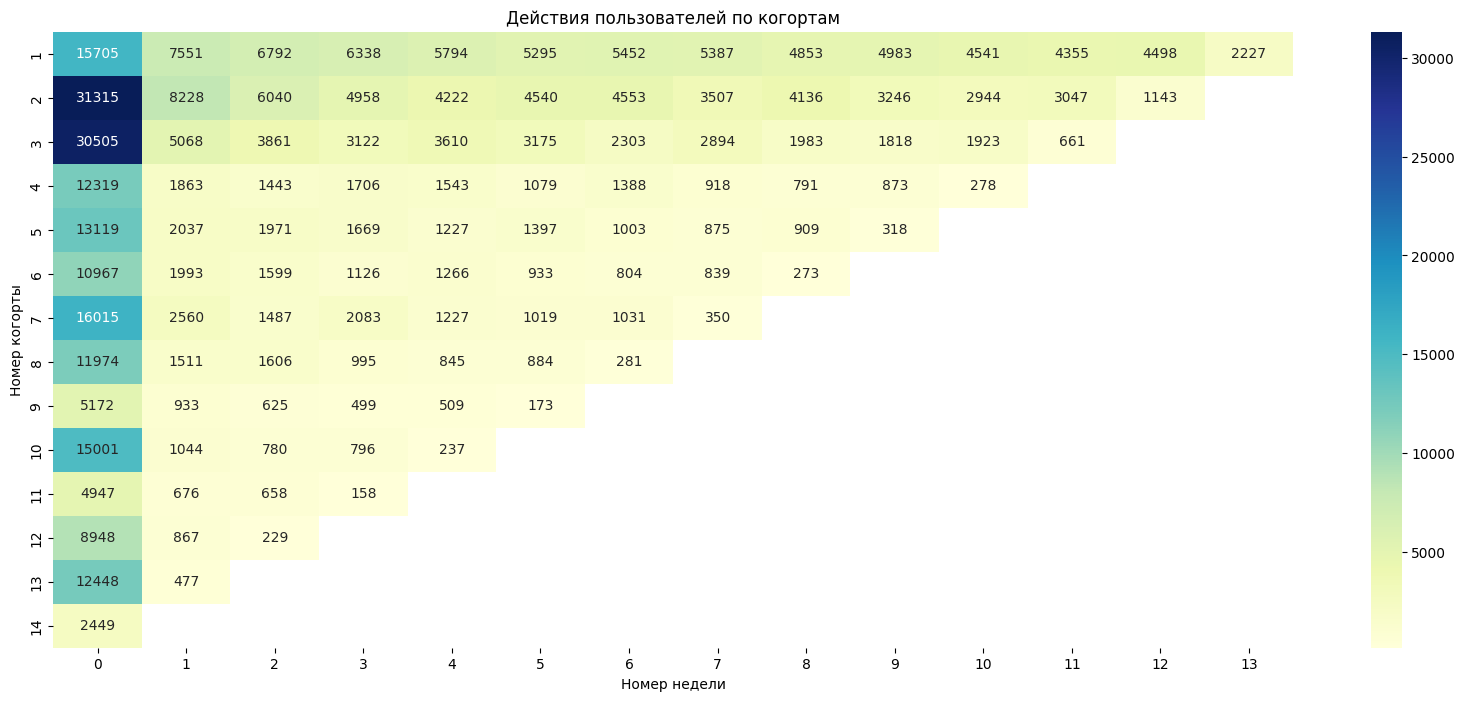

In [28]:
# строим таблицу по действиям, совершенных пользователями разных когорт по неделям
cohorts_app_start_behavior = user_behavior_cohort_start_app.pivot_table(values = 'device_id',
                                                                        index = 'cohort_start_app',
                                                                        columns = 'week_of_action',
                                                                        aggfunc = 'nunique')
# строим тепловую карту 
fig, axes = plt.subplots(figsize=(20, 8))
ax = sns.heatmap(cohorts_app_start_behavior, annot=True, fmt=".0f", cmap="YlGnBu")
ax.set_title('Действия пользователей по когортам')
ax.set_ylabel('Номер когорты')
ax.set_xlabel('Номер недели');

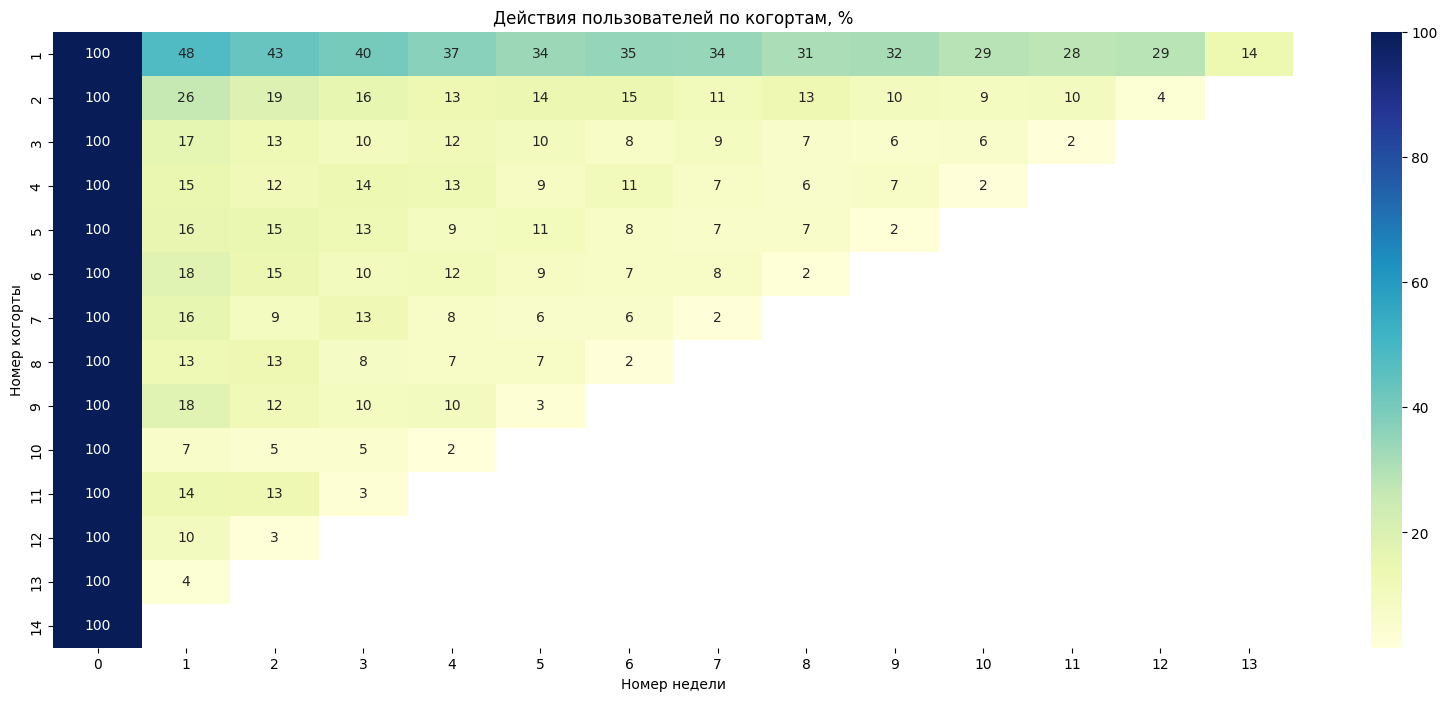

In [29]:
# строим таблицу по действиям, совершенных пользователями разных когорт по неделям в относительном выражении
cohorts_app_start_behavior_per = cohorts_app_start_behavior.apply(lambda x: x*100/cohorts_app_start_behavior[0])
# строим тепловую карту 
fig, axes = plt.subplots(figsize=(20, 8))
ax = sns.heatmap(cohorts_app_start_behavior_per, annot=True, fmt=".0f", cmap="YlGnBu")
ax.set_title('Действия пользователей по когортам, %')
ax.set_ylabel('Номер когорты')
ax.set_xlabel('Номер недели');

Наиболее активные пользователи относятся к первой когорте. Чем более поздняя дата когорты, тем менее она активна. Следовательно, рекламные компании становятся менее эффективны.

Рассмотрим когорты по дате регистрации в приложении.

In [30]:
# добавляем в основную таблицу дату регистрации пользователей
user_behavior = user_behavior.merge(user_behavior_pivot[['device_id', 'register']],
                                    on = 'device_id',
                                    how = 'left')
# копируем таблицу для проведения когортного анализа по дате регистрации
user_behavior_cohort_register = user_behavior.copy()
# добавляем столбец с номером недели когорты
user_behavior_cohort_register['cohort_register'] = user_behavior_cohort_register['register'].dt.isocalendar().week
# заменяем пустые значения для пользователей, которые вообще не зарегистрировались
user_behavior_cohort_register['cohort_register'] = user_behavior_cohort_register['cohort_register'].fillna (0)
# удаляем из таблицы пользователей, которые так и не зарегистрировались
user_behavior_cohort_register = user_behavior_cohort_register[user_behavior_cohort_register['cohort_register'] != 0]
# добавляем столбец с неделей жизни когорты на момент совершения действия
user_behavior_cohort_register['week_of_action'] = user_behavior_cohort_register.apply(lambda x: int(x['week_of_date'] - int(x['cohort_register'])), axis = 1)

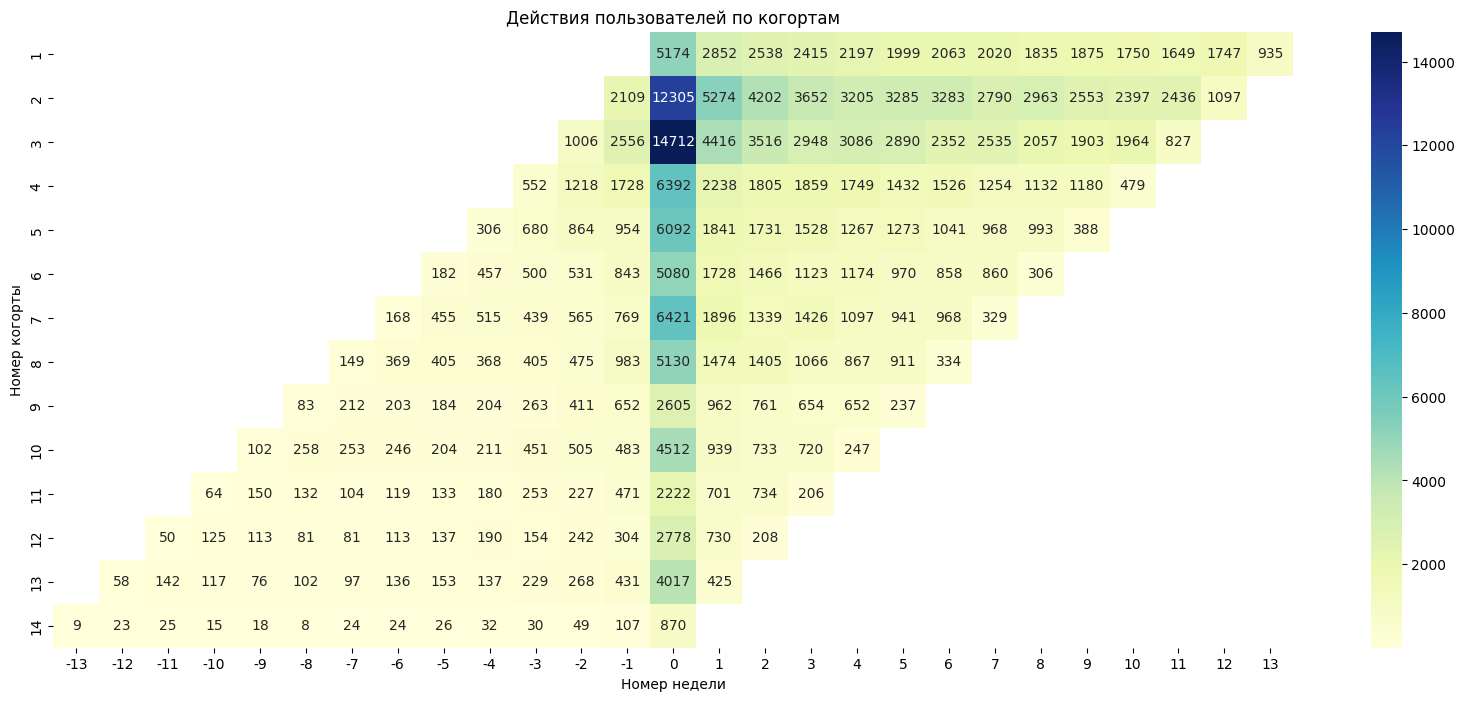

In [31]:
# строим таблицу по действиям, совершенных пользователями разных когорт по неделям
user_behavior_cohort_register_piv = user_behavior_cohort_register.pivot_table(values = 'device_id',
                                              index = 'cohort_register',
                                              columns = 'week_of_action',
                                              aggfunc = 'nunique')
# строим тепловую карту 
fig, axes = plt.subplots(figsize=(20, 8))
ax = sns.heatmap(user_behavior_cohort_register_piv, annot=True, fmt=".0f", cmap="YlGnBu")
ax.set_title('Действия пользователей по когортам')
ax.set_ylabel('Номер когорты')
ax.set_xlabel('Номер недели');

Исходя из данных тепловой карты можно сделать вывод о том, что множество пользователей используют приложение до регистрации. Чем позже дата начала когорты, тем дольше пользователи используют приложения без регистрации. Также, максимальное число зарегистрированных в одну неделю относятся к когортам 2 и 3.

Рассмотрим когорты по дате первой покупки.

In [32]:
# добавляем столбец с номером недели когорты
user_behavior['cohort_purchase'] = user_behavior['first_purchase'].dt.isocalendar().week
# заменяем пустые значения для пользователей, которые не совершали покупки
user_behavior['cohort_purchase'] = user_behavior['cohort_purchase'].fillna (0)

In [33]:
# копируем таблицу для проведения когортного анализа по дате первой покупки
user_behavior_cohort_purchase = user_behavior[user_behavior['event']=='purchase'].copy()
# добавляем столбец с неделей жизни когорты на момент совершения действия
user_behavior_cohort_purchase['week_of_action'] = user_behavior_cohort_purchase.apply(lambda x: int(x['week_of_date'] - int(x['cohort_purchase'])), axis = 1)

In [38]:
# строим таблицу по действиям, совершенных пользователями разных когорт по неделям
user_behavior_cohort_purchase_piv_sum = user_behavior_cohort_purchase.pivot_table(values = 'purchase_sum',
                                              index = 'cohort_purchase',
                                              columns = 'week_of_action',
                                              aggfunc = 'sum')
# вычисляем совокупный доход по когортам
user_behavior_cohort_purchase_piv_sum['LTV'] = user_behavior_cohort_purchase_piv_sum.sum(axis=1)
user_behavior_cohort_purchase_piv_sum.style.background_gradient(subset='LTV', cmap='Blues').format("{:.1f}")


week_of_action,0,1,2,3,4,5,6,7,8,9,10,11,12,13,LTV
cohort_purchase,,,,,,,,,,,,,,,
1,3558860.5,1255280.5,992076.5,883233.0,805830.5,702143.0,646391.5,634483.5,584806.5,583159.0,490457.0,509859.5,543310.0,130286.5,12320177.5
2,8919234.5,1771483.5,1411945.5,1240655.0,939791.5,1006558.5,931625.5,856063.5,728917.0,701897.5,526803.5,638229.5,114633.0,nan,19787838.0
3,10589801.0,1623783.5,1207718.0,889391.0,818894.0,719284.0,737875.5,613872.5,607749.0,412128.0,508907.0,123048.5,nan,nan,18852452.0
4,4907695.5,747083.0,521446.0,477168.5,514961.0,466404.5,374464.0,347886.5,297802.0,311080.5,52058.0,nan,nan,nan,9018049.5
5,4346041.5,611271.5,438043.0,461528.5,398260.0,316876.5,270943.0,247240.5,271541.5,70888.0,nan,nan,nan,nan,7432634.0
6,3855562.5,546723.0,506553.0,382793.0,289561.0,302178.0,185490.0,209118.5,27258.0,nan,nan,nan,nan,nan,6305237.0
7,4515630.5,611119.5,455673.5,354512.5,272615.5,228958.5,271054.5,56749.5,nan,nan,nan,nan,nan,nan,6766314.0
8,3576614.0,524632.0,442594.0,309370.0,241054.5,257278.5,47294.5,nan,nan,nan,nan,nan,nan,nan,5398837.5
9,2027450.0,409674.0,244445.0,152695.0,195626.0,37743.5,nan,nan,nan,nan,nan,nan,nan,nan,3067633.5


Как мы видим, самый большой LTV у когорты №2, а самый маленький у когорты № 14. Это объясняется сроком жизни когорт. При этом, несмотря на более длинный срок жизни когорты №1, ее LTV ниже, чем у когорт № 2 и 3. Возможно, у данных когорт выше средний чек или количество заказов.

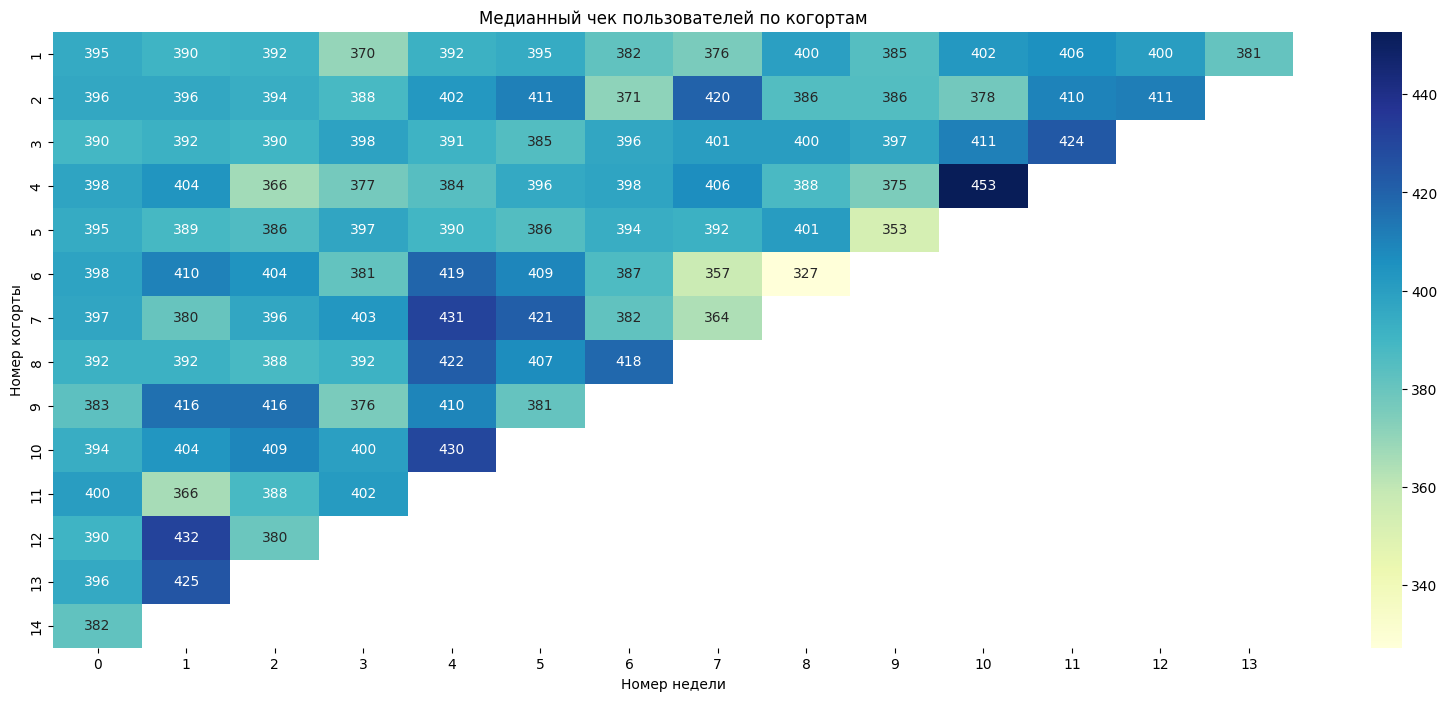

In [35]:
# строим таблицу по действиям, совершенных пользователями разных когорт по неделям
user_behavior_cohort_purchase_piv_median = user_behavior_cohort_purchase.pivot_table(values = 'purchase_sum',
                                              index = 'cohort_purchase',
                                              columns = 'week_of_action',
                                              aggfunc = 'median')
# строим тепловую карту 
fig, axes = plt.subplots(figsize=(20, 8))
ax = sns.heatmap(user_behavior_cohort_purchase_piv_median, annot=True, fmt=".0f", cmap="YlGnBu")
ax.set_title('Медианный чек пользователей по когортам')
ax.set_ylabel('Номер когорты')
ax.set_xlabel('Номер недели');

Как мы видим, медианный средний чек на первую неделю жизни когорт примерно одинаково и находится в диапазоне от 382 рублей до 400 рублей. На вторую неделю жизни когорты медианный средний чек падает у 11 когорты до 366 рубей, а у 12 когорты возрастает до 432. Наибольший медианный средний чек для всех когорт на 5 неделю жизни когорты и находится в диапазоне от 384 до 430 рублей.

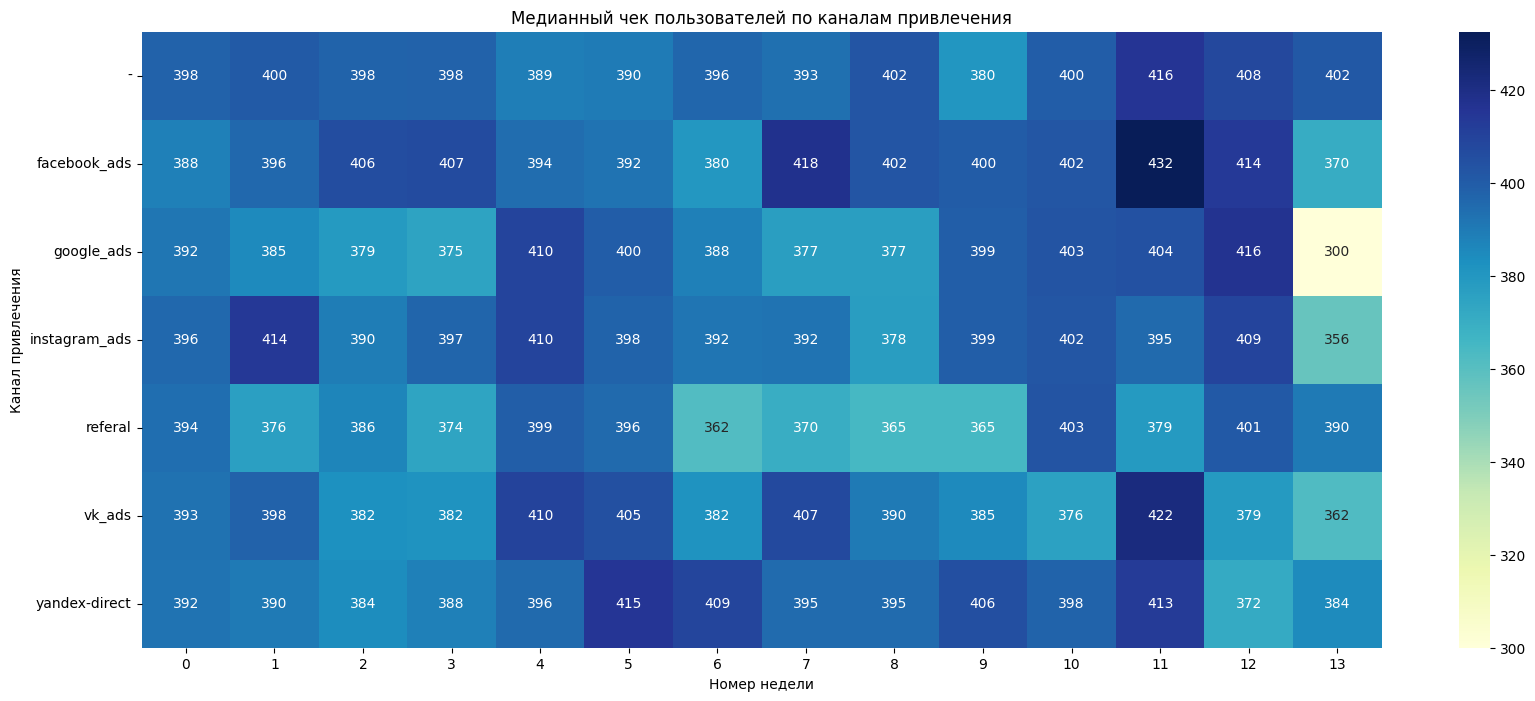

In [36]:
# строим таблицу по действиям, совершенных пользователями по неделям в зависимости от каналов привлечения
user_behavior_cohort_purchase_sours_piv = user_behavior_cohort_purchase.pivot_table(values = 'purchase_sum',
                                              index = 'utm_source',
                                              columns = 'week_of_action',
                                              aggfunc = 'median')
# строим тепловую карту 
fig, axes = plt.subplots(figsize=(20, 8))
ax = sns.heatmap(user_behavior_cohort_purchase_sours_piv, annot=True, fmt=".0f", cmap="YlGnBu")
ax.set_title('Медианный чек пользователей по каналам привлечения')
ax.set_ylabel('Канал привлечения')
ax.set_xlabel('Номер недели');

In [37]:
# вычисляем совокупный доход по когортам
user_behavior_cohort_purchase_sours_piv['median'] = user_behavior_cohort_purchase_sours_piv.median(axis=1)
user_behavior_cohort_purchase_sours_piv.style.background_gradient(subset='median', cmap='Blues').format("{:.1f}")

week_of_action,0,1,2,3,4,5,6,7,8,9,10,11,12,13,median
utm_source,,,,,,,,,,,,,,,
-,398.0,400.5,397.5,398.0,389.0,390.0,396.5,393.2,402.5,380.5,399.5,415.5,408.0,401.5,398.0
facebook_ads,388.5,396.0,406.0,407.0,394.2,392.5,380.0,418.0,402.5,400.0,402.2,432.5,413.8,370.5,401.1
google_ads,391.5,385.0,379.0,375.0,409.5,399.5,388.5,377.0,377.0,399.0,403.0,404.5,416.5,300.0,390.0
instagram_ads,396.0,414.0,389.5,397.0,409.5,397.5,392.0,392.5,377.5,399.0,402.0,395.2,409.2,356.2,396.5
referal,393.8,376.2,386.5,374.5,399.0,395.5,362.0,370.0,365.0,365.0,403.0,379.0,401.0,390.2,382.8
vk_ads,393.0,398.0,382.5,382.0,410.0,405.0,382.0,407.2,390.5,385.0,376.0,421.8,379.0,362.5,387.8
yandex-direct,392.5,390.5,384.2,388.0,395.8,415.0,409.0,395.0,395.0,405.5,397.5,413.0,371.8,384.5,395.0


Из тепловой карты понятно, что медианный средний чек на первую неделю активности примерно одинаков и составляет от 388 до 398 рублей. К последней неделе медианный средний чек падает у всех платных каналов привлечения. Сильнее всего к последней неделе медианный чек падает у Инстраграм (до 300 рублей). При этом медианный средний чек за весь срок жизни когорт по каналам привлечения наибольший медианный средний чек у Фэйсбук (402,2 рублей), а наименьший у реферальной программы (386,5 рублей).

# Выводы
1) Пики активности действий всех пользователей всех групп выпадают на 10 января, 6 марта, 14 февраля, 14 января и 21 февраля 2020 года. В эти же даты отмечается максимальная доля трафика с инсталлов. Возможно эти даты совпадают с началом каких-то рекламных акций или распродаж. Минимальное количество действий пользователями совершено 01, 04, 06 января, что может быть связано с новогодними праздниками и 31 марта.
Количество открытий приложений пользователями из группы "Установили в тот же день" превышает количество открытий приложений пользователями из группы "Остальные" только дважды: 01 января и 10 января. Доля действий новых пользователей в данные дни является максимальной. 
2) Большинство зарегистрированных пользователей отсеивается на 5 шаге - подтверждении покупки. При этом, минимум 69% пользователей перешедших, в корзину подтверждают покупку. большинство незарегистрированных пользователей отсеивается на 4 шаге - регистрации пользователей, которая является обязательной для оформления заказа. При этом, пользователи, прошедшие регистрацию, совершают покупку минимум в 85%. 
3) Больше всего установок приносят такие каналы как Яндекс (29386), Гугл (26286) и ВК (23189), а меньше всего с реферальной программы (9282). Наибольшее количество новых пользователей пришло с Яндекс.Директ (18%), Гугл (16,5%) и ВК (14,5%). Медианный средний чек за первую покупку по всем платным каналом привлечения находится в интервале от 389 до 395 рублей. Наименьший медианный средний чек за первую покупку у Фейсбук (389 руб.), наибольший у реферальной программы (395.5 руб.) и Инстаграм (393.5 руб.). Наибольшая конверсия по каналам привлечения у реферальной программы (48%) и Фэйсбук (42%), а самый маленький у Яндекс.Директ (32%). Наибольшая выручка по каналам привлечения у ВК (16389652.5 руб.) и Инстаграм (14546969 руб.), а самый маленький у реферальной программы (8837044.5 руб.) и Фэйсбук (12249901 руб.).
4) Наиболее эффективным каналом относительно затрат является реферальная программа. Из платных каналов наиболее высокий ROMI у ВК(90%), самый низкий у Гугл (22%).
5) Проведя когортный анализ по дате первого использования приложения можно сделать вывод, что наиболее активные пользователи относятся к 1 когорте. На вторую неделю срока жизни когорты в ней сохранилось 48% пользователей, а к концу срока жизни когорты в ней сохранилось 14% пользователей. Второй по активности является 2 когорта. На вторую неделю срока жизни когорты в ней сохранилось 26% пользователей, а к концу срока жизни когорты в ней сохранилось 4% пользователей. Чем более поздняя дата когорты, тем менее она активна. Следовательно, рекламные компании становятся менее эффективны.
7) Проведя когортный анализ по дате первой покупки можно сделать вывод, что самая большаю выручка у 2 когорты (19787838 руб.), а самая маленькая у 14 когорты (584207 руб). Это объясняется сроком жизни когорт. При этом, несмотря на более длинный срок жизни первой 1 (12320177.5 руб.), ее выручка ниже, чем у когорт 2 и 3 (18852452 руб.). Возможно, у данных когорт выше средний чек или количество заказов. Медианный средний чек на первую неделю жизни когорт примерно одинаково и находится в диапазоне от 382 рублей до 400 рублей. На вторую неделю жизни когорты медианный средний чек падает у 11 когорты до 366 рубей, а у 12 когорты возрастает до 432. Наибольший медианный средний чек для всех когорт на 5 неделю жизни когорты и находится в диапазоне от 384 до 430 рублей.
Также, медианный средний чек на первую неделю активности примерно одинаков и составляет от 388 до 398 рублей. К последней неделе медианный средний чек падает у всех платных каналов привлечения. Сильнее всего к последней неделе медианный чек падает у Инстраграм (до 300 рублей). При этом медианный средний чек за весь срок жизни когорт по каналам привлечения наибольший медианный средний чек у Фэйсбук (402,2 рублей), а наименьший у реферальной программы (386,5 рублей).

# Рекомендаци
1) Проанализировать процедуру регистрации пользователей и упростить ее для уменьшения уровня отсеивания пользователей на этапе регистрации.
2) По итогам анализа каналов привечения пользователей можно сделать вывод, что следует осуществить дополнительные вложения в каналы с максимальной конверсией (наличие наиболее заинтересованной аудитории) и наибольшим средним чеком (наличие наиболее платежеспособной аудитории). 
- реферальная программа; ROMI у данного канала привлечения более 600%, следовательно, можно увеличить по ней выплаты, повысив заинтересованность пользователей;
- Инстаграм;
- ВК.
